# PLA animation

*Milan Malfait*

Notebook containing an animation of the Perceptron Learning Algorithm.

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

from matplotlib import animation, rc
from IPython.display import HTML
plt.rcParams['animation.html'] = 'html5'

#matplotlib preamble
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 14, 7
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

# The Perceptron Learning Algorithm

## Creating an artificial dataset

### Defining a random target function

To test the PLA algorithm, an artificial dataset is first created using an arbitrary target function $f$. For this, the function `target(p1, p2, x)` is created. This function will take two points `p1` and `p2` as input and define the target function $f$ as the **straight line** that goes through these two points. The y-coordinate is then calculated for the given x, based on this linear equation.

In [2]:
def target(p1, p2, x):
    '''
    Defines a 2-dimensional target function based on two given points p1 and p2 as the straight line that goes 
    through them and returns the y-coordinate corresponding to a given x-coordinate
    p1, p2 should be 2-dimensionional, x should be a scalar
    '''
    m = (p2[1] - p1[1]) / (p2[0] - p1[0])  # slope of the line
    b = p1[1] - m*p1[0]
    
    y = m*x + b  # output y from input x
    
    return y

### Creating artificial datasets

This target function will then be used to separate the input data in two sets that will have a different label (the output $Y$). The input data consists of $N$ 2-dimensional vectors $\textbf{X}$ of the form $(x_1, x_2)$.

In the cell below, random data is generated and the output calculated. The output $Y$ is considered binary, being either $1$ or $-1$. Finally, the data points are plotted and labeled according to their output, as well as the target function.

In [3]:
def get_dataset(d, N):
    '''
    Generates an atrificial dataset that can be used for perceptron learning, in the form of a set of input
    vectors, their associated output and the target function that produced the output.
    
    Parameters:
    -----------
        * d : integer, dimension of the data input vectors X = (x1, x2, ..., xd)
        * N : integer, size of the dataset, i.e. the number of data points
        
    Returns:
    --------
        * X_arr : numpy array, N*d matrix containing the input vectors X
        * Y_arr : numpy array, N-dimensional vector containing the outputs associated with the input vectors
        * f : lambda function, the target function associated with the dataset
    '''
    space = [0, 1]  # range for the values of x1 and x2 of the input

    # Generating data; using a loop that ensures both positive and negative outputs are acquired
    while True:
        # Generate 2 random points (between 0 and 1) from which the target function will be defined
        p1 = np.random.uniform(space[0], space[1], 2)
        p2 = np.random.uniform(space[0], space[1], 2)
    
        # defining the target function
        f = lambda x: target(p1, p2, x)
    
        # Generate N random input vectors X, stored in a N*d array
        X_arr = np.random.uniform(space[0], space[1], [N, d])
    
        # Calculate outputs Y from each X based on target function, stored in N*1 array
        Y_arr = np.empty(N)
        
        for i in range(N):
            x1 = X_arr[i, 0]
            x2 = X_arr[i, 1]
            Y_arr[i] = np.sign(x2 - f(x1))
    
        # Check if there are both positive and negative outputs
        pos = np.argwhere(Y_arr > 0)
        neg = np.argwhere(Y_arr < 0)
        if len(pos) and len(neg):
            break
            
    return X_arr, Y_arr, f

## The Algorithm

In [4]:
def pla(training_in, training_out, max_iters=None):
    '''
    Finds the approximation of the unknown target function associated with the given training set according to
    the Perceptron Learning Algorithm.
    
    Parameters:
    -----------
        * training_in : numpy array, contains the input vectors of the training dataset
        * training_out : numpy array, contains the outputs associated with the corresponding input vectors
        * max_iters : int (optional), the maximum number of iterations that the algorithm will run (default None)
    
    Returns:
    --------
        * w : numpy array, vector containing the weights of the PLA after training
        * iters : integer, number of iterations before the PLA converged
        * all_weights : list, contains the history of weights from each iteration during learning
    '''
    training_in = np.array(training_in)
    training_out = np.array(training_out)
    
    assert np.shape(training_in)[0] == np.shape(training_out)[0], \
            "Training input and output have incompatible dimensions."
    
    # Introduce the x0 dimension (x0 = 1), store all input vectors in a N*d matrix
    X_matrix = np.hstack((np.ones((len(training_in), 1)), training_in))
    
    # Initialize d-dimensional weights vector to 0
    w = np.zeros(np.shape(X_matrix)[1])
    all_weights = [w]  # list to store all weights generated during training (used for animation)
    
    iters = 0                          # current number of iterations
    predictions = np.sign(X_matrix@w)  # current output of the perceptron, as a N-dimensional vector
    
    while any(predictions != training_out):
        iters += 1  # update number of iterations
        if max_iters is not None:
            if iters >= max_iters:
                print("PLA did not converge after %s iterations" %(iters))
                break
        
        misclassified = np.argwhere(predictions != training_out)     # indexes of misclassified data (N*1 array)
        i = misclassified[np.random.randint(len(misclassified)), 0]  # choose a random index
        yn = training_out[i]
        xn = X_matrix[i]
        
        w = w + yn*xn                       # update weights vector
        all_weights.append(w)               # add weights vector to list
        predictions = np.sign(X_matrix@w)   # make new predictions
        
    return w, iters, all_weights

## Visualization and animation of the PLA

The line $w_1x_1 + w_2x_2 + w_0 = 0$ defines the line (in 2-dimensional space) that approximates the target function according to the PLA. Can also be written as:

$$ x_2 = -\frac{w_1}{w_2} x_1 - \frac{w_0}{w_2} $$

Using the all_weights list returned by the `pla()` function, which contains the weights vectors generated at each iteration, the learning can be animated.

The code for the animation was based on the following tutorial:
http://tiao.io/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/

To ensure the animation works properly, one should install the ffmpeg package which can be done with anaconda in the command line:

`conda install -c conda-forge ffmpeg`

In [5]:
# generating dataset
d = 2                   # number of dimensions for the input data
size = 100              # dataset size

data = get_dataset(d, size)
X, Y, f = data

In [6]:
# Running the PLA
w, iters, weights = pla(X, Y)

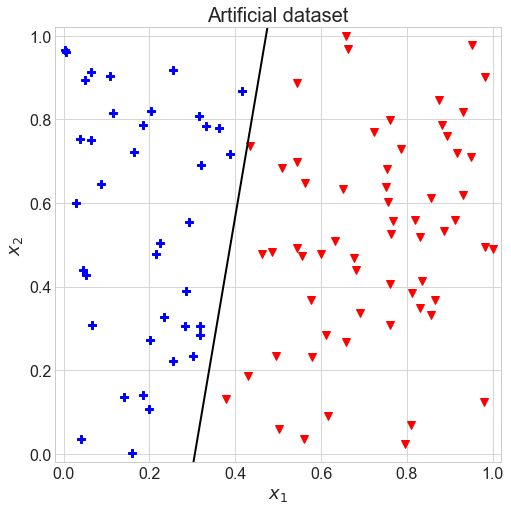

In [7]:
# Setting up the plot containing the dataset for the animaition

fig, ax = plt.figure(figsize=(8, 8)), plt.axes()

pos = np.argwhere(Y > 0)
neg = np.argwhere(Y < 0)
    
ax.plot(X[pos, 0], X[pos, 1], 'bP', linestyle='none', label='y = +1');  # datapoints with positive Y
ax.plot(X[neg, 0], X[neg, 1], 'rv', linestyle='none', label='y = -1');  # datapoints with negative Y

# plotting the target function f
x = np.linspace(0, 1, 2) # 2 numbers between 0 and 1
ax.plot(x, f(x), 'k-', label='Target function');

# the line plot representing the hypothesis that will be animated (initially empty)
line, = ax.plot([], [], 'm-', lw=2);

ax.set_title('Artificial dataset');
ax.set_xlabel(r'$x_1$');
ax.set_ylabel(r'$x_2$');
ax.set_xlim(-0.02, 1.02);
ax.set_ylim(-0.02, 1.02);

In [8]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

In [20]:
# animation function. This is called sequentially
def animate(i):
    if i > iters:
        i = -1
        
    w = weights[i]
    g = lambda x: -(w[1]/w[2])*x - (w[0]/w[2])
    
    x = np.linspace(0, 1, 1000)
    y = g(x)
    line.set_data(x, y)
    return (line,)

In [21]:
# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=100, interval=100, blit=True)

In [22]:
anim

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys
